In [1]:
%matplotlib inline

In [2]:
#!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv as catboost_cv
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, GridSearchCV,
                                     KFold, LeaveOneOut, LeavePOut)
# --- Import scikit-learn metrics directly ---
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

from scipy.stats import randint, uniform
import optuna # Added import
from imblearn.over_sampling import RandomOverSampler # Added import

# Import necessary functions from utils.py (excluding metrics)
from utils import (
    plot_pred_vs_actual_plotly,
    plot_shap_summary,
    plot_shap_waterfall,
    plot_shap_dependence,
    plot_native_feature_importance # Keep native importance plot
    # Removed RMSE, MAPE, calculate_r2 from utils import
)

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [4]:
DATA_PATH = "data/conso_data.csv"
TARGET_COLUMN = "pitd"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Features for special handling
FEATURES_TO_QUANTIZE = ['pitd1'] # Features for custom quantization
CUSTOM_BORDER_COUNT = 1024         # Border count for specific quantization
MONOTONE_CONSTRAINTS_CONFIG = {'teff_cwv': -1} # Monotonic constraints {'feature_name': direction}

# Tuning settings
N_ITER_RANDOM_SEARCH = 30 # Iterations for RandomizedSearchCV
N_TRIALS_OPTUNA = 40      # Trials for Optuna optimization
CV_FOLDS_TUNING = 3       # Folds for CV during tuning

# File to save/load best parameters
PARAMS_FILENAME = 'best_catboost_params.json'

# Oversampling settings
HOLIDAY_COLUMN = 'is_holiday' # *** IMPORTANT: ASSUMING this column exists or will be created ***
ENABLE_OVERSAMPLING = False

GRID_SEARCH_POINTS = 3 # Number of points per continuous parameter in Grid Search (e.g., 3 = low, center, high)
GRID_SEARCH_RANGE_FACTOR = 0.15 

In [5]:
df = pd.read_csv("data/conso_data.csv")

In [6]:
# Calculate Heating Degree Days (HDD)
base_temp = 16.5
# Ensure 'tmoy' is numeric before calculation
df['tmoy'] = pd.to_numeric(df['tmoy'], errors='coerce')
df['hdd'] = (base_temp - df['tmoy']).clip(lower=0)

In [7]:
# Convert object to category
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

In [8]:
X = df.drop(columns="pitd") #target
y = df['pitd']

In [9]:
num_variables = X.columns[X.dtypes == 'float64'].tolist()
cat_variables = X.columns[X.dtypes == 'category'].tolist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
features_to_quantize_names = ['pitd1'] 
custom_border_count = 1024 

quantization_settings = []
if features_to_quantize_names:
    print(f"Configuration de la quantification personnalisée (border_count={custom_border_count}) pour: {features_to_quantize_names}")
    valid_feature_indices = {}
    for feature_name in features_to_quantize_names:
        valid_feature_indices[feature_name] = X_train.columns.get_loc(feature_name)
    quantization_settings = [f'{idx}:border_count={custom_border_count}' for name, idx in valid_feature_indices.items()]
    
float_features = X_train.select_dtypes(include=np.float64).columns.tolist()
float_feature_indices = {name: i for i, name in enumerate(X_train.columns) if name in float_features}

Configuration de la quantification personnalisée (border_count=1024) pour: ['pitd1']


In [12]:
params_filename = 'best_random_search_params.json'

In [13]:
if not os.path.exists(params_filename):

    cb_estimator = CatBoostRegressor(cat_features=cat_variables, verbose = 0, monotone_constraints = {'hdd': 1}, per_float_feature_quantization= quantization_settings)
    param_dist = {
        'iterations': randint(500, 2000),
        'learning_rate': uniform(0.01, 0.2),
        'depth': randint(4, 10),
        'l2_leaf_reg': uniform(1, 10),
        'border_count': randint(32, 256),

        #'monotone_constraints': [
        #    {'teff_cwv': -1},
        #    {'hdd': 1},
        #    {'teff_cwv': -1, 'hdd': 1}
        #],
    #
        #'per_float_feature_quantization': [ 
        #    [f'{float_feature_indices["pitd1"]}:{CUSTOM_BORDER_COUNT}'] if "pitd1" in float_feature_indices else None,
        #    ([f'{float_feature_indices["pitd1"]}:512', f'{float_feature_indices["hdd"]}:64']
        #     if "pitd1" in float_feature_indices and "hdd" in float_feature_indices else None)
        #]
    }


    random_search = RandomizedSearchCV(
        estimator=cb_estimator,
        param_distributions=param_dist,
        n_iter=N_ITER_RANDOM_SEARCH,
        cv=CV_FOLDS_TUNING,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE
    )

    fit_params = {
        'early_stopping_rounds': 50 
    }

    best_params_random = {}
    best_score_rs = -np.inf
    final_model_rs = None
    rs_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
    try:
        random_search.fit(X_train, y_train, **fit_params)
        if hasattr(random_search, 'best_params_'):
            best_params_random = random_search.best_params_
            best_score_rs = random_search.best_score_
            print(f"Best Internal CV Score (Negative RMSE): {best_score_rs:.4f}")
            print(f"Equivalent Best RMSE: {-best_score_rs:.4f}")
            print(json.dumps(best_params_random, indent=4))

            with open(params_filename, 'w') as f:
                json.dump(best_params_random, f, indent=4) 
        else:
            print("Randomized Search did not find best parameters.")
    except Exception as e:
        print(f"\nError during Randomized Search fit: {e}")

In [14]:
with open(params_filename, 'r') as f:
    best_params_random = json.load(f)

In [15]:
final_model_rs = CatBoostRegressor(cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_random)
final_model_rs.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0, plot=False) 
print("\n--- Randomized Search Final Model Evaluation ---")

y_pred_rs = final_model_rs.predict(X_test)
rmse_rs = root_mean_squared_error(y_test, y_pred_rs)
mape_rs = mean_absolute_percentage_error(y_test, y_pred_rs) * 100
r2_rs = r2_score(y_test, y_pred_rs)
print(f"Test RMSE: {rmse_rs:.2f}, MAPE: {mape_rs:.2f}%, R2: {r2_rs:.4f}")
rs_model_metrics = {'RMSE': rmse_rs, 'MAPE': mape_rs, 'R2': r2_rs}


--- Randomized Search Final Model Evaluation ---
Test RMSE: 10836.04, MAPE: 2.65%, R2: 0.9977


In [ ]:
params_filename = 'best_params_gs.json' 
if not os.path.exists(params_filename):
    # comparer optuna et grid search 
    fit_params = {
            'early_stopping_rounds': 50 
        }
    center_iterations = best_params_random.get('iterations', 1000)
    center_lr = best_params_random.get('learning_rate', 0.05)
    center_depth = best_params_random.get('depth', 6)
    center_l2 = best_params_random.get('l2_leaf_reg', 3)
    center_border = best_params_random.get('border_count', 128)
    best_rs_constraints = best_params_random.get('monotone_constraints', None)
    best_rs_quantization = best_params_random.get('per_float_feature_quantization', None)
    # --- Create the new, tighter, and more populated grid ---

    param_grid_gs = {

        'iterations': [
            int(max(100, center_iterations * 0.95)), # ~ -10%
            center_iterations,                      # center
            int(center_iterations * 1.05),           # ~ +10%
        ],


        'learning_rate': np.linspace(center_lr * 0.9, center_lr * 1.1, 3).tolist(),

        'depth': list(range(max(2, center_depth - 1), center_depth + 2)),

        'l2_leaf_reg': np.linspace(center_l2 * 0.9, center_l2 * 1.1, 3).tolist(),

        'border_count': list(np.unique( # Use unique to avoid duplicates if steps are small
            [
                int(max(32, center_border * 0.90)), # ~ -25%
                center_border,
                int(min(255, center_border * 1.1 ))  # ~ +25% (adjust max 255 if needed)
            ]
        ).astype(int))
    }


    cb_estimator_gs = CatBoostRegressor(
        cat_features=cat_variables,
        loss_function='RMSE', eval_metric='RMSE',
        monotone_constraints=best_rs_constraints,             
        per_float_feature_quantization=best_rs_quantization, 
        verbose=0,
    )


    grid_search = GridSearchCV(
        estimator=cb_estimator_gs, param_grid=param_grid_gs, cv=CV_FOLDS_TUNING,
        scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1 )


    best_params_gs = {}
    best_score_gs = -np.inf
    final_model_gs = None
    gs_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}
    try:
        grid_search.fit(X_train, y_train, **fit_params)
        if hasattr(grid_search, 'best_params_'):
            best_params_gs = grid_search.best_params_
            best_score_gs = grid_search.best_score_
            print(f"Best Internal CV Score (Negative RMSE): {best_score_gs:.4f}")
            print(f"Equivalent Best RMSE: {-best_score_gs:.4f}")
            print("Best Parameters Found by Grid Search:")
            print(json.dumps(best_params_gs, indent=4))
            best_params_gs['border_count'] = int(best_params_gs['border_count'])
            params_filename = 'best_gs_params.json' 
            with open('best_params_gs.json', "w") as f:
                json.dump(best_params_gs, f, indent=4)
        else:
            print("Grid Search did not find best parameters.")
    except Exception as e:
        print(f"\nError during Grid Search fit: {e}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GP

Best Internal CV Score (Negative RMSE): -12552.3883
Equivalent Best RMSE: 12552.3883
Best Parameters Found by Grid Search:

Error during Grid Search fit: Object of type int64 is not JSON serializable


In [24]:
params_filename = 'best_params_gs.json' 
with open(params_filename, 'r') as f:
    best_params_gs = json.load(f)
final_gs_params = best_params_gs.copy()
final_gs_params['monotone_constraints'] = best_rs_constraints
final_gs_params['per_float_feature_quantization'] = best_rs_quantization
final_model_gs = CatBoostRegressor(cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **final_gs_params)
final_model_gs.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0, plot=False)
print("\n--- Grid Search Final Model Evaluation ---")
y_pred_gs = final_model_gs.predict(X_test)
rmse_gs = root_mean_squared_error(y_test, y_pred_gs)
mape_gs = mean_absolute_percentage_error(y_test, y_pred_gs) * 100
r2_gs = r2_score(y_test, y_pred_gs)
print(f"Test RMSE: {rmse_gs:.2f}, MAPE: {mape_gs:.2f}%, R2: {r2_gs:.4f}")
gs_model_metrics = {'RMSE': rmse_gs, 'MAPE': mape_gs, 'R2': r2_gs}


--- Grid Search Final Model Evaluation ---
Test RMSE: 11015.44, MAPE: 2.72%, R2: 0.9976


In [ ]:
N_TRIALS_OPTUNA_FOCUSED = 40
def objective_focused(trial):
    param = {
        'objective': 'RMSE', 'loss_function': 'RMSE', 'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE, 'cat_features': cat_variables,
        'verbose': 0, 'early_stopping_rounds': 50,

        'iterations': trial.suggest_int('iterations', int(max(100, center_iterations * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(center_iterations * (1 + GRID_SEARCH_RANGE_FACTOR*1.5))), # Slightly wider range than GS
        'learning_rate': trial.suggest_float('learning_rate', max(0.001, center_lr * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_lr * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
        'depth': trial.suggest_int('depth', max(2, center_depth - 1), center_depth + 1), # Tight range around best depth
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', max(0.01, center_l2 * (1 - GRID_SEARCH_RANGE_FACTOR*1.5)), center_l2 * (1 + GRID_SEARCH_RANGE_FACTOR*1.5), log=True),
        'border_count': trial.suggest_int('border_count', int(max(32, center_border * (1 - GRID_SEARCH_RANGE_FACTOR*1.5))), int(min(255, center_border * (1 + GRID_SEARCH_RANGE_FACTOR*1.5)))),

        'monotone_constraints': best_rs_constraints,
        'per_float_feature_quantization': best_rs_quantization}

    cv = KFold(n_splits=CV_FOLDS_TUNING, shuffle=True, random_state=RANDOM_STATE)
    rmses = []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # Optional Oversampling (inside fold)
        if ENABLE_OVERSAMPLING and HOLIDAY_COLUMN in X_t.columns: pass # Placeholder
        try:
            model_cv = CatBoostRegressor(**param)
            model_cv.fit(X_t, y_t, eval_set=[(X_v, y_v)])
            preds = model_cv.predict(X_v)
            fold_rmse = root_mean_squared_error(y_v, preds)
            rmses.append(fold_rmse)
        except Exception as e:
             print(f"Warning: Optuna trial fold {fold+1} failed: {e}")
             return np.inf 
    if not rmses: return np.inf
    return np.mean(rmses)

study_focused = optuna.create_study(direction='minimize')
print(f"Running Focused Optuna study for {N_TRIALS_OPTUNA_FOCUSED} trials...")
study_focused.optimize(objective_focused, n_trials=N_TRIALS_OPTUNA_FOCUSED)

print("Focused Optuna Optimization Finished.")
best_params_optuna_focused = {}
best_value_optuna_focused = np.inf
final_model_optuna_focused = None
optuna_focused_model_metrics = {'RMSE': np.inf, 'MAPE': np.inf, 'R2': -np.inf}

if study_focused.best_trial:
    trial_focused = study_focused.best_trial
    best_value_optuna_focused = trial_focused.value
    print(f"  Value (RMSE): {best_value_optuna_focused:.4f}")
    print("  Best Parameters Found by Focused Optuna: ")
    best_params_optuna_focused = trial_focused.params
    if 'monotone_constraints' not in best_params_optuna_focused:
        best_params_optuna_focused['monotone_constraints'] = best_rs_constraints
    if 'per_float_feature_quantization' not in best_params_optuna_focused:
        best_params_optuna_focused['per_float_feature_quantization'] = best_rs_quantization
    print(json.dumps(best_params_optuna_focused, indent=4))
    with open('best_params_opt.json', "w") as f:
        json.dump(best_params_optuna_focused,f, indent=4)
else:
     print("Focused Optuna study did not complete successfully or found no best trial.")


[I 2025-04-15 22:27:25,768] A new study created in memory with name: no-name-7000c88b-d6ed-44d2-9eec-d2b0ae944bce


Running Focused Optuna study for 40 trials...


[I 2025-04-15 22:29:02,941] Trial 0 finished with value: 12485.156150210043 and parameters: {'iterations': 1392, 'learning_rate': 0.16765443937794208, 'depth': 3, 'l2_leaf_reg': 7.2212620933707665, 'border_count': 179}. Best is trial 0 with value: 12485.156150210043.
[I 2025-04-15 22:32:49,192] Trial 1 finished with value: 15574.827149905299 and parameters: {'iterations': 1388, 'learning_rate': 0.18448481120930232, 'depth': 5, 'l2_leaf_reg': 7.923749610794528, 'border_count': 194}. Best is trial 0 with value: 12485.156150210043.
[I 2025-04-15 22:36:00,740] Trial 2 finished with value: 15720.579016885189 and parameters: {'iterations': 1303, 'learning_rate': 0.17875925553392688, 'depth': 5, 'l2_leaf_reg': 6.10596032254227, 'border_count': 155}. Best is trial 0 with value: 12485.156150210043.
[I 2025-04-15 22:38:34,849] Trial 3 finished with value: 14859.012905311552 and parameters: {'iterations': 1639, 'learning_rate': 0.20070667166909414, 'depth': 5, 'l2_leaf_reg': 7.342910848075747, 'b

Focused Optuna Optimization Finished.
  Value (RMSE): 12145.1490
  Best Parameters Found by Focused Optuna: 
{
    "iterations": 1800,
    "learning_rate": 0.1615052852629874,
    "depth": 3,
    "l2_leaf_reg": 7.232237574790942,
    "border_count": 198,
    "monotone_constraints": null,
    "per_float_feature_quantization": null
}

Training final model using best parameters from Focused Optuna...

--- Focused Optuna Final Model Evaluation ---


NameError: name 'X_test_original' is not defined

In [27]:
with open('best_params_opt.json', "r") as f:
        best_params_optuna_focused= json.load(f)
final_model_optuna_focused = CatBoostRegressor(
    cat_features=cat_variables, loss_function='RMSE', eval_metric='RMSE', random_seed=RANDOM_STATE, **best_params_optuna_focused)
final_model_optuna_focused.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=0, plot=False)
print("\n--- Focused Optuna Final Model Evaluation ---")
y_pred_optuna_focused = final_model_optuna_focused.predict(X_test)
rmse_optuna_focused = root_mean_squared_error(y_test, y_pred_optuna_focused)
mape_optuna_focused = mean_absolute_percentage_error(y_test, y_pred_optuna_focused) * 100
r2_optuna_focused = r2_score(y_test, y_pred_optuna_focused)
print(f"Test RMSE: {rmse_optuna_focused:.2f}, MAPE: {mape_optuna_focused:.2f}%, R2: {r2_optuna_focused:.4f}")
optuna_focused_model_metrics = {'RMSE': rmse_optuna_focused, 'MAPE': mape_optuna_focused, 'R2': r2_optuna_focused}



--- Focused Optuna Final Model Evaluation ---
Test RMSE: 10640.39, MAPE: 2.68%, R2: 0.9978



--- Overall Model Comparison & Analysis ---
Loading previously trained external models...
Loaded model 'Baseline' from models/cb_base_model.cbm
  Calculating metrics for loaded model 'Baseline'...
  Metrics for 'Baseline': RMSE=12582.95, MAPE=2.94%, R2=0.9969
Loaded model 'TimeAware' from models/cb_time_model.cbm
  Calculating metrics for loaded model 'TimeAware'...
  Metrics for 'TimeAware': RMSE=12675.04, MAPE=3.10%, R2=0.9968
Loaded model 'Golden' from models/cb_golden_model.cbm
  Calculating metrics for loaded model 'Golden'...
  Metrics for 'Golden': RMSE=10522.53, MAPE=2.37%, R2=0.9978

Combining all models for comparison...
Added 'RandomSearch' model.
Added 'GridSearch_FineTuned' model.
Added 'Optuna_FineTuned' model.
Found 6 valid models for comparison: ['Baseline', 'TimeAware', 'Golden', 'RandomSearch', 'GridSearch_FineTuned', 'Optuna_FineTuned']

Creating final metrics comparison table...

Combined Model Performance Comparison on Test Set:
                           RMSE   M

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and TimeAware. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'Golden'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and Golden. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'RandomSearch'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Baseline' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Baseline and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'Golden'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and Golden. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'RandomSearch'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'TimeAware' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare TimeAware and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'RandomSearch'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Golden and RandomSearch. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Golden and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'Golden' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare Golden and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'RandomSearch' vs 'GridSearch_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare RandomSearch and GridSearch_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'RandomSearch' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare RandomSearch and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable

Comparing 'GridSearch_FineTuned' vs 'Optuna_FineTuned'...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Comparison Summary (RMSE):
  Could not compare GridSearch_FineTuned and Optuna_FineTuned. Error: 'NoneType' object is not subscriptable


--- Final Model Analysis (Overall Best) ---
Selected 'Golden' as best model based on lowest Test RMSE.

Analyzing model: Golden

Plotting native feature importance...


/home/onyxia/work/PY-Gaz-Consumption-Prediction/utils.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importances', y='Feature Id', data=feature_importance.head(top_n), palette='viridis')


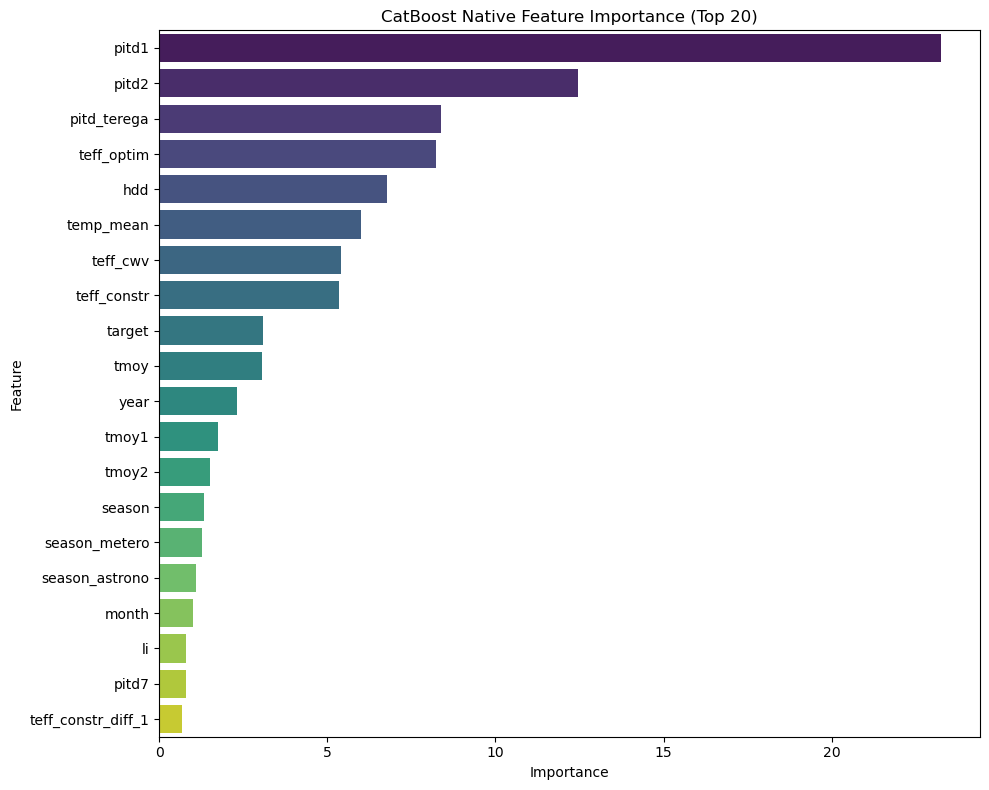


Generating SHAP plots...


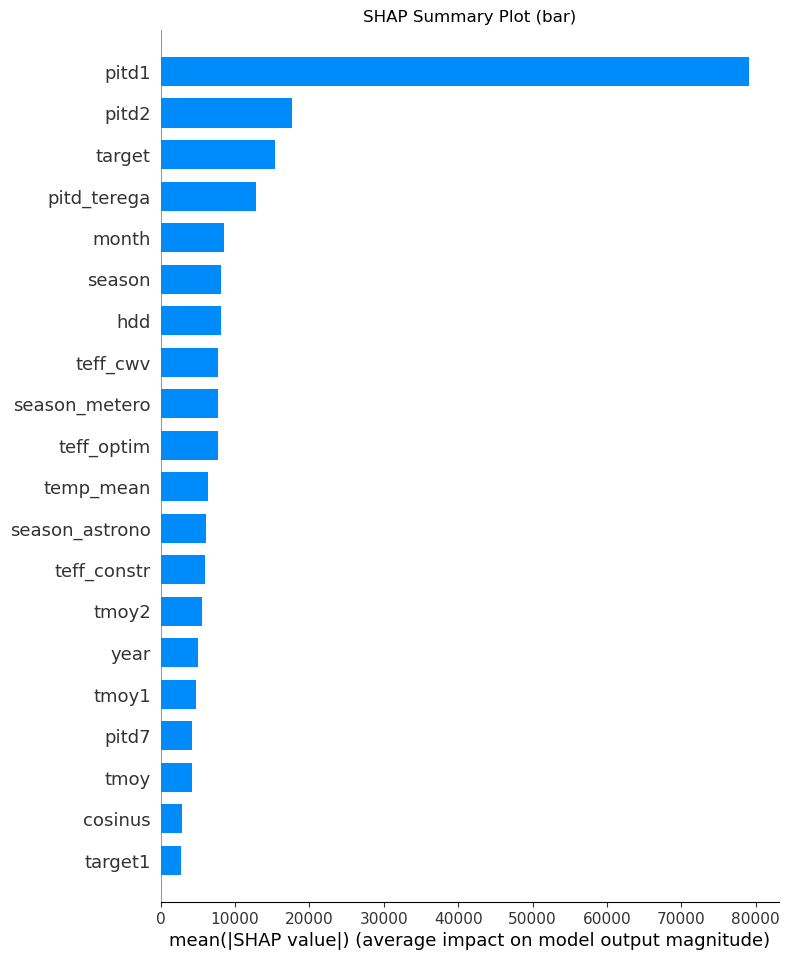

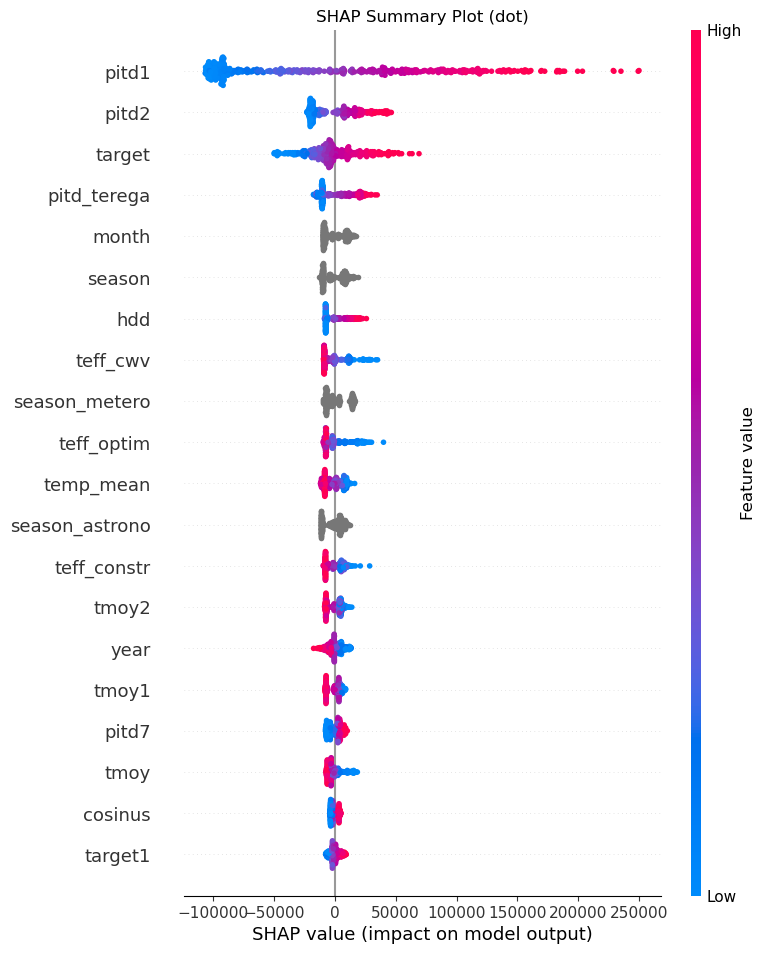

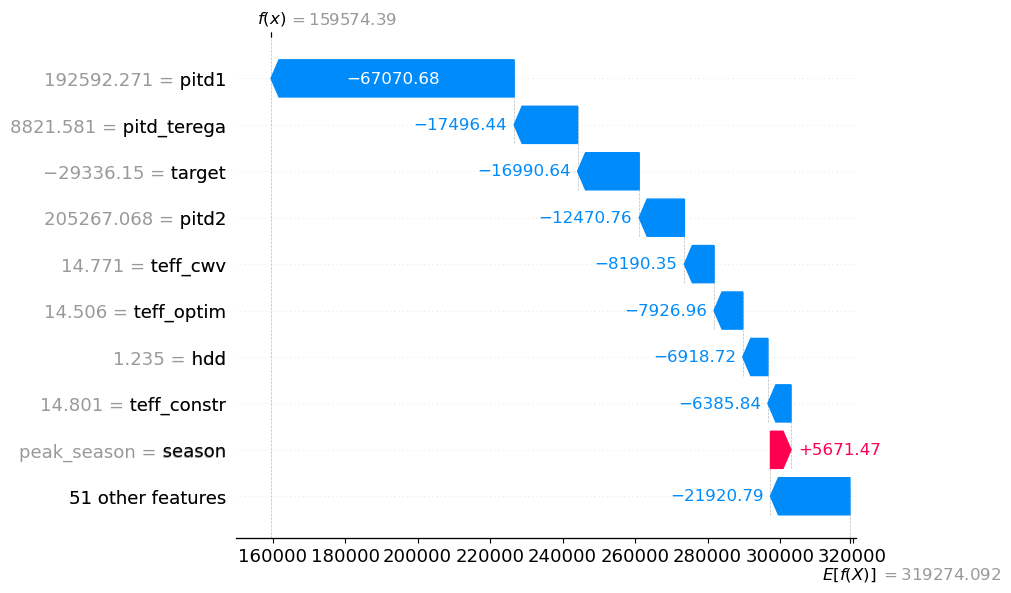


Script section finished.


In [30]:
# %% [markdown]
# # 4. Overall Model Comparison & Final Analysis

# %%
print("\n" + "="*50)
print("--- Overall Model Comparison & Analysis ---")

# --- Define paths and Load External Models ---
print("Loading previously trained external models...")
models_to_load_paths = {
    "Baseline": 'models/cb_base_model.cbm',
    "TimeAware": 'models/cb_time_model.cbm',
    "Golden": 'models/cb_golden_model.cbm',
}
loaded_models = {}
model_metrics_recalculated = {} # Store metrics calculated from loaded models

# Or ensure RMSE, MAPE, calculate_r2 are imported from utils if using those

for name, path in models_to_load_paths.items():
    try:
        model = CatBoostRegressor() # Initialize empty model
        model.load_model(path)
        loaded_models[name] = model
        print(f"Loaded model '{name}' from {path}")

        # --- Calculate metrics for the loaded model ---
        print(f"  Calculating metrics for loaded model '{name}'...")
        y_pred_loaded = model.predict(X_test) # Use the consistent test set
        # Using sklearn metrics directly:
        rmse_loaded = root_mean_squared_error(y_test, y_pred_loaded)
        mape_loaded = mean_absolute_percentage_error(y_test, y_pred_loaded) * 100
        r2_loaded = r2_score(y_test, y_pred_loaded)
        # Store metrics
        model_metrics_recalculated[name] = {'RMSE': rmse_loaded, 'MAPE': mape_loaded, 'R2': r2_loaded}
        print(f"  Metrics for '{name}': RMSE={rmse_loaded:.2f}, MAPE={mape_loaded:.2f}%, R2={r2_loaded:.4f}")

    except Exception as e:
        print(f"Error loading or evaluating model '{name}' from {path}: {e}. Skipping.")

# --- Combine All Models (Loaded + Internally Trained) ---
print("\nCombining all models for comparison...")
all_models_to_compare = {}
all_models_to_compare.update(loaded_models) # Add loaded models first

# Add models trained within this script (check if they exist and are fitted)
if 'final_model_rs' in locals() and final_model_rs is not None and final_model_rs.is_fitted():
    all_models_to_compare["RandomSearch"] = final_model_rs
    print("Added 'RandomSearch' model.")
if 'final_model_gs' in locals() and final_model_gs is not None and final_model_gs.is_fitted():
    all_models_to_compare["GridSearch_FineTuned"] = final_model_gs
    print("Added 'GridSearch_FineTuned' model.")
if 'final_model_optuna_focused' in locals() and final_model_optuna_focused is not None and final_model_optuna_focused.is_fitted():
    all_models_to_compare["Optuna_FineTuned"] = final_model_optuna_focused
    print("Added 'Optuna_FineTuned' model.")

# Filter for valid, fitted models
valid_models_to_compare_all = {k: v for k, v in all_models_to_compare.items() if v is not None and v.is_fitted()}
print(f"Found {len(valid_models_to_compare_all)} valid models for comparison: {list(valid_models_to_compare_all.keys())}")

# --- Create Metrics DataFrame (using calculated metrics) ---
print("\nCreating final metrics comparison table...")
all_metrics_data = {}
# Add metrics calculated within this script
if 'rs_model_metrics' in locals(): all_metrics_data['RandomSearch'] = rs_model_metrics
if 'gs_model_metrics' in locals(): all_metrics_data['GridSearch_FineTuned'] = gs_model_metrics
if 'optuna_focused_model_metrics' in locals(): all_metrics_data['Optuna_FineTuned'] = optuna_focused_model_metrics
# Add metrics recalculated from loaded models
all_metrics_data.update(model_metrics_recalculated)

if not all_metrics_data:
     print("Warning: No model metrics available for comparison table.")
     comparison_df_all = pd.DataFrame() # Empty DataFrame
else:
     comparison_df_all = pd.DataFrame(all_metrics_data).T
     # Ensure required columns exist before ordering
     cols_to_show = [col for col in ['RMSE', 'MAPE', 'R2'] if col in comparison_df_all.columns]
     if cols_to_show:
         comparison_df_all = comparison_df_all[cols_to_show]
         print("\nCombined Model Performance Comparison on Test Set:")
         print(comparison_df_all.to_string(float_format="%.4f"))
     else:
         print("Warning: No standard metric columns (RMSE, MAPE, R2) found in metrics data.")
         comparison_df_all = pd.DataFrame() # Reset if no valid columns



if len(valid_models_to_compare_all) < 2:
    print("Need at least two valid trained models to compare.")
else:
    # Create comparison pool (uses original test set)
    # Ensure Pool is imported: from catboost import Pool
    try:
        comparison_pool = Pool(data=X_test, label=y_test, cat_features=cat_variables)
        model_names_all = list(valid_models_to_compare_all.keys())
        # Loop through unique pairs
        for i in range(len(model_names_all)):
            for j in range(i + 1, len(model_names_all)):
                name1 = model_names_all[i]
                name2 = model_names_all[j]
                model_obj1 = valid_models_to_compare_all[name1]
                model_obj2 = valid_models_to_compare_all[name2]

                print(f"\nComparing '{name1}' vs '{name2}'...")
                try:
                    # --- MODIFIED: Use the model.compare() method syntax ---
                    # Note: Metrics are passed as a list, e.g., ['RMSE']
                    comp_df = model_obj1.compare(
                        model_obj2,
                        comparison_pool,
                        metrics=['RMSE'] # Use the 'metrics' argument as a list
                    )
                    # --- End Modification ---

                    # Display summary stats (assuming output DataFrame structure is similar)
                    print("Comparison Summary (RMSE):")
                    # Adjust column names here if the output DataFrame is different
                    print(comp_df[['metric_name', 'model1_wins', 'model2_wins', 'metric_value_diff']].head())

                except Exception as e:
                    print(f"  Could not compare {name1} and {name2}. Error: {e}")

    except NameError as ne:
         print(f"Error creating comparison pool or accessing models: {ne}")
         print("Ensure X_test, y_test, and cat_variables are defined.")
    except Exception as ex:
         print(f"An unexpected error occurred during comparison setup: {ex}")

print("="*50 + "\n")



# --- Final Model Analysis (Choose Overall Best based on Metrics Table) ---
print("\n--- Final Model Analysis (Overall Best) ---")
final_model_to_analyze = None
best_model_name = None

if not comparison_df_all.empty and 'RMSE' in comparison_df_all.columns:
     try:
         # Select model with lowest RMSE from the metrics table
         best_model_name = comparison_df_all['RMSE'].astype(float).idxmin() # Ensure RMSE is float for idxmin
         print(f"Selected '{best_model_name}' as best model based on lowest Test RMSE.")
         # Get the corresponding model object from the valid models dictionary
         final_model_to_analyze = valid_models_to_compare_all.get(best_model_name)
     except Exception as e:
          print(f"Could not determine best model from metrics table: {e}")

if final_model_to_analyze and final_model_to_analyze.is_fitted():
    print(f"\nAnalyzing model: {best_model_name}")
    print("\nPlotting native feature importance...")
    # Ensure X_train exists and has columns for feature names
    if 'X_train' in locals() and hasattr(X_train, 'columns'):
        final_feature_names = X_train.columns.tolist()
        plot_native_feature_importance(final_model_to_analyze, final_feature_names)
    else:
        print("Warning: Cannot get feature names for native importance plot (X_train not available?).")

    print("\nGenerating SHAP plots...")
    # Ensure X_test exists for SHAP plots
    if 'X_test' in locals():
        plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="bar")
        plot_shap_summary(final_model_to_analyze, X_test, final_feature_names, plot_type="dot")
        plot_shap_waterfall(final_model_to_analyze, X_test, final_feature_names, instance_index=1)
    else:
        print("Warning: Cannot generate SHAP plots (X_test not available?).")
else:
    print("No final best model available for analysis (either none found or selection failed).")

print("\n" + "="*50)
print("Script section finished.")